# Try DBSCAN on PCAd and non-PCAd data

In [1]:
import os
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn import decomposition, metrics
from sklearn.preprocessing import scale, robust_scale
from sklearn.cluster import DBSCAN
#from sklearn.manifold import TSNE
%matplotlib inline

In [2]:
# Read in data
filename = '/Users/tswenson/Documents/Joels/Health_Data_Science/COMPANY_consulting_project/datasets/merged_csvs/LABELLED_by_cell_type_screen_525_cell_plate_1_well_c03.csv'
my_data=pd.read_csv(filename, index_col=0)

In [3]:
# Find data columns
my_data_headers = list(my_data)
meta_headers = ["Width","cell_label","cell_plate","lineage","screen","well","Time"]
my_data_data_headers = [x for x in my_data_headers if not x in meta_headers]
# Scale the data columns
my_scaled_data = scale(my_data[my_data_data_headers])
# Make a list where cell_label is converted to numbers for plotting
word_as_num=[]
for word in my_data['cell_label']:
    if word == "unlabelled":
        word_as_num.append("0")
    if word == "blast":
        word_as_num.append("0.5")
    if word == "healthy":
        word_as_num.append("1")

In [4]:
# Do PCA
# Perform PCA
pca = decomposition.PCA()
pca.fit(my_scaled_data)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

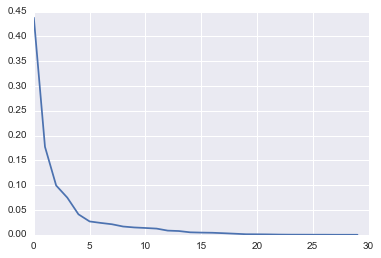

In [5]:
# Plot var explained per component
#The amount of variance that each PC explains
var=pca.explained_variance_ratio_
plt.plot(var)

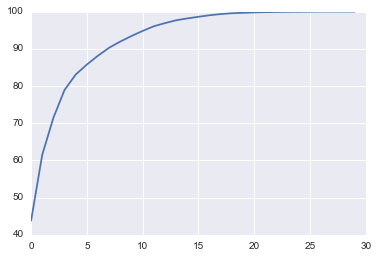

In [6]:
#Cumulative Variance explains
var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
plt.plot(var1)

In [7]:
# Transform my data based on the PCA results
pca = decomposition.PCA(n_components = 10)
my_scaled_data_transformed = pca.fit_transform(my_scaled_data)

In [8]:
# Convert transformed data into a pandas dataframe and then combine it with the meta data
my_scaled_data_transformed_pd = pd.DataFrame(my_scaled_data_transformed)

# Combine it with the meta data
my_scaled_data_transformed_pd_meta = pd.concat([my_scaled_data_transformed_pd, my_data[meta_headers]], axis=1);
# Note that the above line works because they have the same index, if they didn't and I 
## wanted to perform a cbind, I could say my_scaled_data_transformed_pd.reset_index(drop=True)

In [9]:
print(my_data[meta_headers].head(n=2))
print("NEXT------------------------")
print(my_scaled_data_transformed_pd.head(n=2))
print("NEXT------------------------")
print(my_scaled_data_transformed_pd_meta.head(n=2))

    Width  cell_label    cell_plate lineage      screen      well    Time
0  5288.0  unlabelled  cell_plate_1  parent  screen_525  well_c03  8377.0
1    36.0  unlabelled  cell_plate_1  parent  screen_525  well_c03  8377.0
NEXT------------------------
           0          1          2          3          4          5  \
0  43.121483 -13.213300  84.447944  65.967352  62.290093 -12.051840   
1  -0.722782   0.013042   1.482393  -0.021735   0.747183   0.620735   

           6         7         8         9  
0 -20.514745 -6.116189 -1.487342  5.565701  
1   1.950386  0.500923  0.290363  0.043255  
NEXT------------------------
           0          1          2          3          4          5  \
0  43.121483 -13.213300  84.447944  65.967352  62.290093 -12.051840   
1  -0.722782   0.013042   1.482393  -0.021735   0.747183   0.620735   

           6         7         8         9   Width  cell_label    cell_plate  \
0 -20.514745 -6.116189 -1.487342  5.565701  5288.0  unlabelled  cell_plate_1 

In [10]:
# Do DBSCAN on the PCAd data
print("Starting DBSCAN")
dbsc = DBSCAN(eps = .85,min_samples=10, metric = "euclidean").fit(my_scaled_data_transformed_pd)
labels = dbsc.labels_
core_samples = np.zeros_like(labels, dtype = bool)
core_samples[dbsc.core_sample_indices_] = True
unique_labels = np.unique(labels)

Starting DBSCAN


In [11]:
DB_PCA = [] # This will be a list of lists where the 1st entry is the cluster ID, 2nd: is
## how many "unlabelled" are in that cluster, 3rd: number of blast, 4th: number of healthy.
for i in xrange(len(unique_labels)):
    clst_index = my_data['cell_label'][np.where(labels==unique_labels[i])[0]]
    if clst_index.empty == True:
        print("Cluster index and original data don't line up right. STOP AND FIX")
        break
    DB_PCA.append([unique_labels[i],sum(clst_index=='unlabelled'),
                     sum(clst_index=='blast'),sum(clst_index=='healthy')])
    #print(str(unique_labels2[i])+"--") # prints cluster name plus two "--"s
    #print len(tsne_out_mink2[np.where(labels2==unique_labels2[i])[0],0]) # prints how many cells are in that cluster
print(DB_PCA) # This was print(tsne_db_2)

[[-1, 970, 34, 57], [0, 7429, 155, 436]]


(34.0, 10000.0)

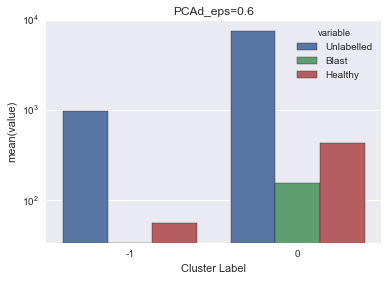

In [12]:
# Convert the list of lists to a pandas dataframe
DB_PCA_df = pd.DataFrame(DB_PCA,columns=["Cluster Label","Unlabelled","Blast","Healthy"])
DB_PCA_df_melted = pd.melt(DB_PCA_df,value_vars=["Unlabelled","Blast","Healthy"],id_vars="Cluster Label")
# Plot the results
ax = sns.barplot(hue="variable",y="value",x="Cluster Label",data=DB_PCA_df_melted,log='y')
plt.title("PCAd_eps=0.6")
plt.ylim(0, plt.ylim()[1])
#plt.ylim(plt.ylim()[0]-100, plt.ylim()[1])

In [ ]:
'''
### Only plot clusters with more than 50 events
tsne_db_df_50 = tsne_db_df[tsne_db_df.sum(axis=1)>50]
tsne_db_df_50_melted = pd.melt(tsne_db_df_50,value_vars=["Unlabelled","Blast","Healthy"],id_vars="Cluster Label")
ax = sns.barplot(hue="variable",y="value",x="Cluster Label",data=tsne_db_df_50_melted,log='y')
plt.savefig('C03_large_clstrs_only__barplot.png')
plt.close()
'''

In [13]:
unique_labels

array([-1,  0])

# Take everything in cluster 0 and then cluster on that 

In [14]:
# Unique_labels is a list of unique cluster labels
# Below line subsets the original data based on what was in a specific cluster (in this case the cluster at index 1 or cluster "0")
my_data_scaled_PCA_DBSCAN0 = my_scaled_data_transformed_pd.iloc[np.where(labels==unique_labels[1])[0]]
my_data_scaled_PCA_DBSCAN0_labels = my_data['cell_label'][np.where(labels==unique_labels[1])[0]]

In [64]:
#my_scaled_data_transformed_pd.iloc[np.where(labels==unique_labels[1])[0]]
#my_data['cell_label'][np.where(labels==unique_labels[1])[0]]

In [30]:
#type(my_data_scaled_PCA_DBSCAN0) # pandas.core.frame.DataFrame
#type(my_data_scaled_PCA_DBSCAN0_labels) # pandas.core.series.Series
#my_data_scaled_PCA_DBSCAN0_labels.head(n=10) # Note the indices are not reset for either of the above pandas objects!!!!

1     unlabelled
2     unlabelled
5     unlabelled
9     unlabelled
18    unlabelled
19    unlabelled
20    unlabelled
25    unlabelled
30    unlabelled
31    unlabelled
Name: cell_label, dtype: object

# Need to reset the index of the pandas object

In [15]:
my_data_scaled_PCA_DBSCAN0 = my_data_scaled_PCA_DBSCAN0.reset_index(drop=True)
my_data_scaled_PCA_DBSCAN0_labels = my_data_scaled_PCA_DBSCAN0_labels.reset_index(drop=True)

In [16]:
# Sanity check is below which should be formalized as a test.
'''
dbsc = DBSCAN(eps = .85,min_samples=10, metric = "euclidean").fit(my_data_scaled_PCA_DBSCAN0)
labels = dbsc.labels_
core_samples = np.zeros_like(labels, dtype = bool)
core_samples[dbsc.core_sample_indices_] = True
unique_labels = np.unique(labels)

# Done with DBSCAN, plot it
DB_PCA = [] # This will be a list of lists where the 1st entry is the cluster ID, 2nd: is
## how many "unlabelled" are in that cluster, 3rd: number of blast, 4th: number of healthy.
print("Double-check that reindexing step below is working the way that you think it is")
for i in xrange(len(unique_labels)):
    clst_index = my_data_scaled_PCA_DBSCAN0_labels[np.where(labels==unique_labels[i])[0]]
    if clst_index.empty == True:
        print("Cluster index and original data don't line up right. STOP AND FIX")
        break
    DB_PCA.append([unique_labels[i],sum(clst_index=='unlabelled'),
                     sum(clst_index=='blast'),sum(clst_index=='healthy')])
    #print(str(unique_labels2[i])+"--") # prints cluster name plus two "--"s
    #print len(tsne_out_mink2[np.where(labels2==unique_labels2[i])[0],0]) # prints how many cells are in that cluster
print(DB_PCA) # This was print(tsne_db_2)
'''
# The output for each cluster from this should block should add up to the cluster it was originally pulled from, so
## sum up element 1, 2 and 3 and make sure that is the same as the cluster you subsetted from

Double-check that reindexing step below is working the way that you think it is
[[0, 7429, 155, 436]]


# Plug in the preprocessed dataset and play with the hyper-parameters for the next round of clustering

In [17]:
eps_param = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.4, 1.8, 3, 6, 12]
algorithm_ = ["auto"]#, "ball_tree","kd_tree","brute"]
metric_ = ["cityblock","euclidean","l1","l2","manhattan",\
           "chebyshev", "canberra","braycurtis"]
### The below were usually uninformative
#           "dice", "hamming", "jaccard", "kulsinski", \
#           "matching", "rogerstanimoto", "russellrao",\
#           "sokalmichener", "sokalsneath", "yule"]


In [18]:
metric_auto_only = [ "braycurtis", "canberra",\
           "dice", "hamming","jaccard", "kulsinski", \
           "matching", "rogerstanimoto", "russellrao",\
           "sokalmichener", "sokalsneath", "yule"]

In [19]:
#metric_ = ["canberra"]
#eps_param = [float(x)/20 for x in list(range(10,50,1))]
#eps_param

In [75]:
metric_ = ["canberra","braycurtis"]

In [19]:
for met in metric_:
    for algo in algorithm_:
        if met in metric_auto_only:
            if algo != "auto":
                continue
        for eps_ in eps_param:
            dbsc = None; labels = None; DB_PCA = None; DB_PCA_df = None;
            # Do DBSCAN on the PCAd data
            print("Starting DBSCAN with EPS of " + str(eps_) + " ALGORITHM of " + algo\
                 + " distance METRIC of " + met)
            dbsc = DBSCAN(eps = eps_,min_samples=10, algorithm = algo, metric = met).fit(my_data_scaled_PCA_DBSCAN0)
            labels = dbsc.labels_
            core_samples = np.zeros_like(labels, dtype = bool)
            core_samples[dbsc.core_sample_indices_] = True
            unique_labels = np.unique(labels)

            # Done with DBSCAN, plot it
            DB_PCA = [] # This will be a list of lists where the 1st entry is the cluster ID, 2nd: is
            ## how many "unlabelled" are in that cluster, 3rd: number of blast, 4th: number of healthy.
            #print("Double-check that reindexing step below is working the way that you think it is")
            for i in xrange(len(unique_labels)):
                clst_index = my_data_scaled_PCA_DBSCAN0_labels[np.where(labels==unique_labels[i])[0]]
                if clst_index.empty == True:
                    print("Cluster index and original data don't line up right. STOP AND FIX")
                    break
                DB_PCA.append([unique_labels[i],sum(clst_index=='unlabelled'),
                                 sum(clst_index=='blast'),sum(clst_index=='healthy')])
                #print(str(unique_labels2[i])+"--") # prints cluster name plus two "--"s
                #print len(tsne_out_mink2[np.where(labels2==unique_labels2[i])[0],0]) # prints how many cells are in that cluster
            print(DB_PCA) # This was print(tsne_db_2)

            # Convert the list of lists to a pandas dataframe
            DB_PCA_df = pd.DataFrame(DB_PCA,columns=["Cluster Label","Unlabelled","Blast","Healthy"])
            DB_PCA_df_melted = pd.melt(DB_PCA_df,value_vars=["Unlabelled","Blast","Healthy"],id_vars="Cluster Label")

            # Plot the results
            plt.gcf().clear()
            ax = sns.barplot(hue="variable",y="value",x="Cluster Label",data=DB_PCA_df_melted,log='y')
            plt.title("DBSCAN results with eps of " + str(eps_))
            plt.ylim(0, plt.ylim()[1])
            plt.savefig(filename + "__PCA10_DBSCAN-euc-0.85-auto_DBSCAN_eps-" + str(eps_) + "_algo-" + algo + "_dist-metric-" + met + "_results.png")
            plt.close()
            print("Done with iteration with EPS of " + str(eps_) + " ALGORITHM of " + algo\
                 + " distance METRIC of " + met)


Starting DBSCAN with EPS of 0.1 ALGORITHM of auto distance METRIC of cityblock
[[-1, 7429, 155, 436]]
Done with iteration with EPS of 0.1 ALGORITHM of auto distance METRIC of cityblock
Starting DBSCAN with EPS of 0.2 ALGORITHM of auto distance METRIC of cityblock
[[-1, 7429, 155, 436]]
Done with iteration with EPS of 0.2 ALGORITHM of auto distance METRIC of cityblock
Starting DBSCAN with EPS of 0.3 ALGORITHM of auto distance METRIC of cityblock
[[-1, 7429, 155, 436]]
Done with iteration with EPS of 0.3 ALGORITHM of auto distance METRIC of cityblock
Starting DBSCAN with EPS of 0.4 ALGORITHM of auto distance METRIC of cityblock
[[-1, 7429, 155, 436]]
Done with iteration with EPS of 0.4 ALGORITHM of auto distance METRIC of cityblock
Starting DBSCAN with EPS of 0.5 ALGORITHM of auto distance METRIC of cityblock
[[-1, 6701, 155, 436], [0, 662, 0, 0], [1, 7, 0, 0], [2, 5, 0, 0], [3, 43, 0, 0], [4, 11, 0, 0]]
Done with iteration with EPS of 0.5 ALGORITHM of auto distance METRIC of cityblock
S

# Note that I need to re-do the indexing if I want to output any of these clusters